# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import tensorflow as tf
# config = tf.ConfigProto(allow_soft_placement = True)
# sess = tf.Session(config = config)
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')

c = tf.matmul(a, b)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


---
## Step 0: Load The Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from __future__ import division
import seaborn as sns

### Data augmentation via rotation, shear and translation (credit Vivek Yadav Blog)

In [3]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
#     ang_rot = 0 
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),0,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
#     b,g,r = cv2.split(img)       # get b,g,r
#     img = cv2.merge([g,b,r])
    return img

### Auxilary function
simple linear regression is used to track accuracy of trained model and stop training to avoid over-fitting

In [4]:
def basic_linear_regression(x, y):
    # Basic computations to save a little time.
    length = len(x)
    sum_x = sum(x)
    sum_y = sum(y)

    # Σx^2, and Σxy respectively.
    sum_x_squared = sum(map(lambda a: a * a, x))
    sum_of_products = sum([x[i] * y[i] for i in range(length)])

    # Magic formulae!
    a = (sum_of_products - (sum_x * sum_y) / length) / (sum_x_squared - ((sum_x ** 2) / length))
    b = (sum_y - a * sum_x) / length
    return a, b

### Experimented with enlarging the image sizes (was not used)

In [5]:
imageOriginalSize = 32
imageSize = 32

# X_train = train['features']
# X_train_dummy = np.empty((X_train.shape[0],imageSize,imageSize,3)) 
# X_test_dummy = np.empty((X_test.shape[0],imageSize,imageSize,3)) 

# for i in range(len(X_train)):
#         X_train_dummy[i] = cv2.cvtColor(cv2.resize(X_train[i].astype('float32'),(imageSize, imageSize), interpolation = cv2.INTER_CUBIC), cv2.COLOR_RGB2BGR)
# for i in range(len(X_test)):
#     X_test_dummy[i] = cv2.cvtColor(cv2.resize(X_test[i].astype('float32'),(imageSize, imageSize), interpolation = cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)

# X_train=X_train_dummy    
# X_test=X_test_dummy

### Experimented with changing image color ordering (was not used)

In [6]:
# def imgConv(img):
#     blue = img[:,:,0]
#     red = img[:,:,2]
#     green = img[:,:,1]
#     stacked = np.stack((blue,green,red),axis=2)
#     return stacked

### Downloading the data

In [7]:
# Load pickled data
import pickle
import sys
# import cPickle
import math
# to set the plt to show true gray scale images set this parameter 
# plt.rcParams['image.cmap'] = 'gray'
# TODO: fill this in based on where you saved the training and testing data
training_file = '/media/pemfir/Data/docker/lab 2 data/train2.p'
testing_file = '/media/pemfir/Data/docker/lab 2 data/test2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


# converting images from some Uni format to float32 for math operation 
# X_train, y_train = train['features'], train['labels']
# X_test, y_test = test['features'], test['labels']

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### Data normalization and scaling

In [8]:
# X_trainScaled = (X_train-np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_trainScaled = (X_train-128.0)/128.0
# X_trainScaled = (X_trainScaled - np.min(X_trainScaled,axis=0))/(np.max(X_trainScaled,axis=0) - np.min(X_trainScaled,axis=0))

# X_train2 = train['features']
# X_testScaled = (X_test-np.mean(X_train2, axis=0))/np.std(X_train2, axis=0)
# X_testScaled = (X_testScaled - np.min(X_testScaled,axis=0))/(np.max(X_testScaled,axis=0) - np.min(X_testScaled,axis=0))
X_testScaled = (X_test-128.0)/128.0
X_trainScaled = X_train
X_testScaled = X_test

### creating validation data

In [9]:
from sklearn.model_selection import train_test_split
# the validation set is created from the training set by randomly splitting the training set into 
# two sets of (10%,90%) of the training set. 
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.10, random_state=100)
X_train, X_validation, _, _  = train_test_split(X_train, y_train , test_size=0.10, random_state=100)
X_trainScaled, X_validationScaled, y_train, y_validation  = train_test_split(X_trainScaled, y_train , test_size=0.10, random_state=100)


### Auxilary Function:
function below generates augmented images on the fly and feed it to the model for training

In [10]:
import copy 
def imageGenerator(batch_x, batch_y,replications):
    # generating new samples for rare classes by randomly rotating exiting images from rare classes by a degree
    # between -20 to 20 degrees
    inputSamples = batch_x.shape[0]
    X_newSamples = copy.deepcopy(batch_x)
    y_newSamples = copy.deepcopy(batch_y)
    samples = range(replications)
    for i in range(inputSamples):
        img = batch_x[i]
        for sample in samples: 
            newSample = transform_image(img,20,10,5)
            newSample = np.reshape(newSample,([1]+list(newSample.shape)))
            X_newSamples = np.vstack((X_newSamples,newSample)) 
            y_newSamples = np.append(y_newSamples,batch_y[i])
    return X_newSamples,y_newSamples

In [11]:
a,b = imageGenerator(X_trainScaled[10:11], y_train[10:11],2)

### Auxilary Function:
function below flattens the images before feeding them to the model for training 

In [12]:
def flatMaker(batch_x):
    return np.reshape( batch_x ,([-1,imageSize*imageSize*3])).astype('float32')


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

# Distribution of data
plotting the histogram of labels in the training data

label 2 has maximum sample size of 2023
label 0 has minimum sample size of 184


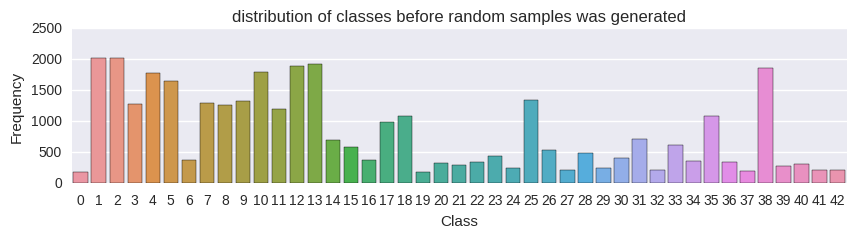

number of samples 35288


In [13]:
# Dictionary labelsCount has the following
# key : is the class label 
# value: is the number of samples from that class in training set. 
labelsCount = {}
for i in y_train:
    labelsCount[i] = 0  
for i in y_train:
    labelsCount[i] += 1
m = 0 
maxValue = ''
mi = 10000 
minValue = ''
for k,v in labelsCount.items():
    if v > m:
        maxValue = (k,v)
        m = v
    if v < mi:
        minValue = (k,v)
        mi = v
overSamplingDict = {}        
for k,v in labelsCount.items():
    # creating new samples based on the how far the sample size is compared to the class with maximum sample size
    # the distance is downscaled using 0.5 exponent further.
    # this was something i learned during in practice for over-sampling
    overSamplingDict[k] = int((maxValue[1] - v)**(0.5) + v) + 500
#     overSamplingDict[k] = labelsCount[k]*10
print('label {0} has maximum sample size of {1}'.format(maxValue[0],maxValue[1]))
print('label {0} has minimum sample size of {1}'.format(minValue[0],minValue[1]))
fig, axes = plt.subplots(1, 1,figsize=(10,2))
sns.barplot(y = list(labelsCount.values()),x=list(labelsCount.keys()))
# plt.plot(list(labelsCount.keys()),list(labelsCount.values()))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('distribution of classes before random samples was generated')
plt.show()
print('number of samples {}'.format(len(y_train)))

In [14]:
# creating a dictionary of labels 
# dictionary labelsDict has:
# keys : class ID
# value: string title of the traffic sign 
import csv
labelsDict = {}
fh = csv.DictReader(open('/media/pemfir/Data/docker/traffic-signs/signnames.csv'))
for line in fh:
    labelsDict[int(line['ClassId'])] = line['SignName']

In [15]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(labelsCount.keys())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## A few samples and their lables from the training set
Created a function for plotting samples and their prediction and true labels

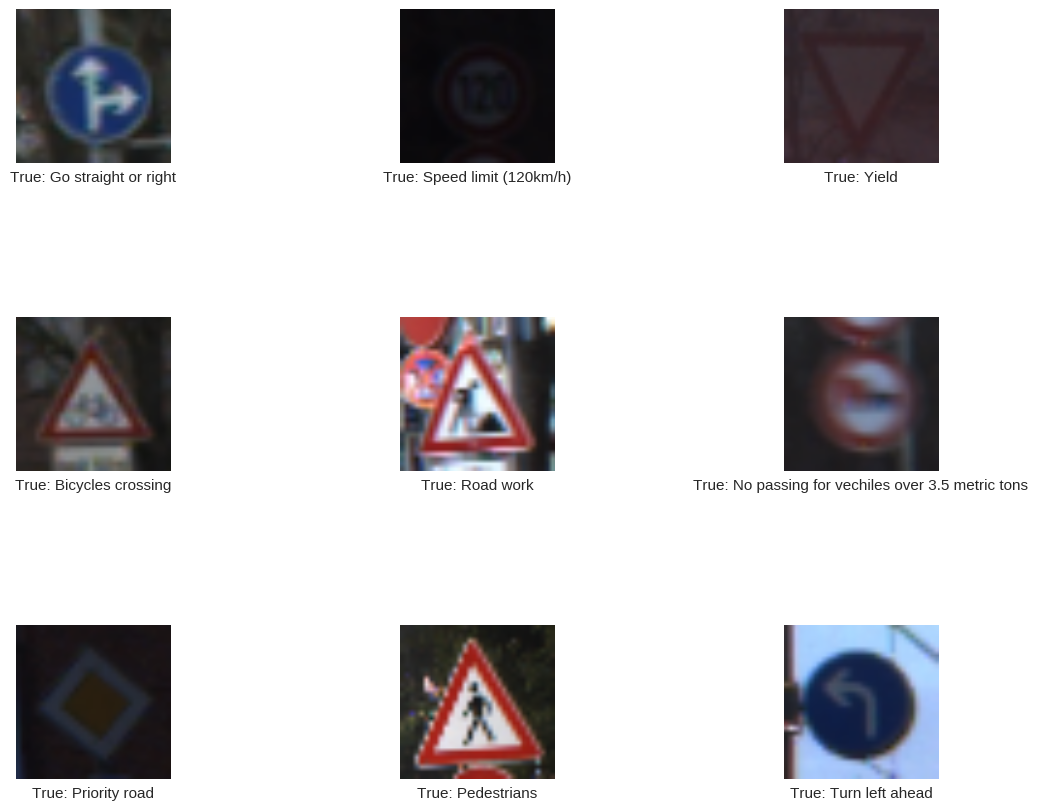

In [16]:
def plot_images(images, trueClass, predictedClass=None):
#     assert len(images) == len(trueClass) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    left  = 0.2  # the left side of the subplots of the figure
    right = 1.4    # the right side of the subplots of the figure
    bottom = .1   # the bottom of the subplots of the figure
    top = 1.5      # the top of the subplots of the figure
    wspace = 1   # the amount of width reserved for blank space between subplots
    hspace = 1   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
#     The parameter meanings (and suggested defaults) are:


#     fig.subplots_adjust(hspace=3, wspace=6)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap="gray")
        xlabel = ''
        if trueClass is not None:
            xlabel = "True: {0}".format(labelsDict[trueClass[i]])
        else : pass
        # Show true and predicted classes.
        
        if predictedClass is None:
            pass
        else:
            xlabel = xlabel + '\n' + 'predicted:\n ' + "\n".join([labelsDict[j] for j in predictedClass[i]])
            #             xlabel = "True: {0},  Pred: {1}".format(labelsDict[cls_true[i]], labelsDict[cls_pred[i]])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def colorInverter(img):
#     img2 = np.empty_like(img)
    return [img[:,:,2],img[:,:,1],img[:,:,0]]
    
import matplotlib.pyplot as plt
# Get the first images from the test-set.
inde = np.random.randint(0, high=10000, size=9, dtype='l')
images = X_train[inde]

# Get the true classes for those images.
trueClass = y_train[inde]

# Plot the images and labels using our helper-function above.
plot_images(images, trueClass)

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [17]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [18]:
### the code for preprocessing can be found above

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

##  Step1:  PreProcessing:
    1- generating additional samples using existing images from rare classes by a random combination of rotation,translation and shear of the existing images. For each training image, 10 new images are generated this way. This means we increase the size of training data 10 folds. Also, since the data is generated on the fly, each epoch is trained on a different set of random images. 
    2- scaling the images. Taking 128 off the pixel values and dividing by 128. I initiallty tried the following but color of images were messed up. First the mean and variance of all training images was calculated. Both test and train set was normialized using the mean and variance. Further using the max and min pixel values, each pixel value was scaled into 0-1 range.
    3- 10% of the training data was preserved for validation. 

### Question 2
Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?


Was answered above. 

**Answer:**

In [19]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


### Model Architecture
    1- i intentionally am explicitely specifying the shape of each layer as a reference for myself
    2- the general structure closely resembles that of the Lenet lab: 3 CONV layers + 2 FC layers
    3- additional changes are as follow:
        a- i keep all color channels in my model (no gray scaling)
        b- i played around with various activation functions and Relu gave me the best performance
        c- i am using drop out with prob = 0.50 during training an prob = 1.0 during prediction
        d- my model has a bit larger in terms of number of parameters as it improved the performance. 
        e- reduced the training step size 0.0001 with AdamOptimizer
        f- L2 regularization 


Model structure downloaded from tensorboard


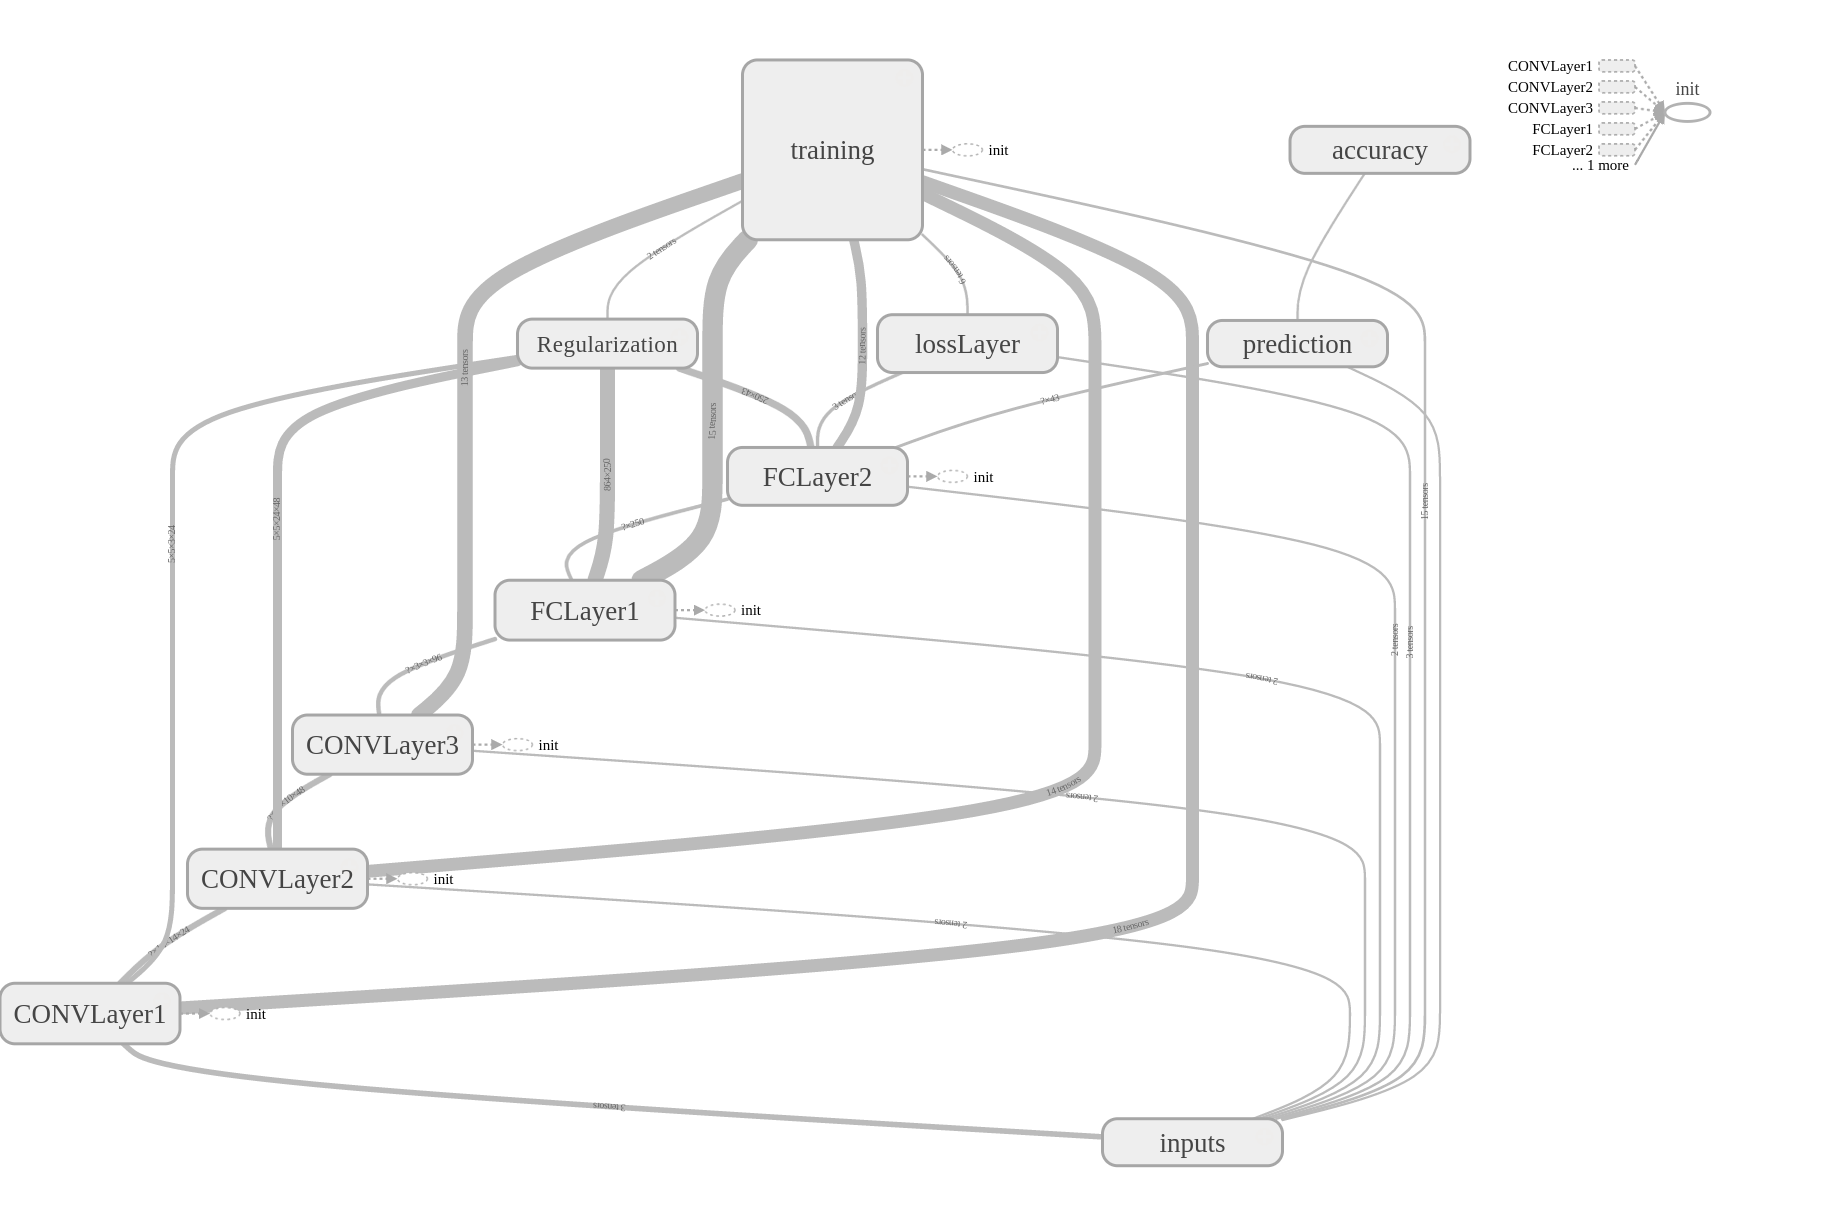

In [20]:
from IPython.display import Image
print('Model structure downloaded from tensorboard')
Image(filename='/home/pemfir/Downloads/model20161228.png')

In [21]:
# shuffling the training set just in case they have a particular order 
from sklearn.utils import shuffle
X_trainScaled, X_train, y_train = shuffle(X_trainScaled,X_train, y_train)
EPOCHS = 120
BATCH_SIZE = 10

## notes for my own understanding of DNN 


when you specify the filter you have specify 4 numbers for its weight as follows:
[filter_size_width, filter_size_height, color_channels or previous layer k_output, k_output]
filter_size_width: each filter is a square patch of pixels here you specify the width of the filter patch 
filter_size_height: here you specify the height of the filter patch 
color_channels or previous layer k_output: if this is your first layer, then this is the number of color channels if this is not the initial layer, then this is the previous layer k_output. This is because this filter is now 
dealing with an image with a pseduo color channels = k_output. 
what the filter in the middle layer does : suppose the output from the previous layer is (20x20x6)
then a filter of size (5x5x6x3) gets a patch of (5x5x6) from the image and flattens it into a vector of size (1,5x5x6), the filter is in fact a (5x5x6,3) matrix. It is similar to logistic regression with an input of size (5x5x6) and 3 classes. Notice this means that we have 3 biases for the layer too. the output of the multiplication is a (1,5x5x6) . (5x5x6,3) = (1,3) , 3 numbers ! each number belongs to a channel of the current layer output.a 5x5x6 filter can be slide on the image of size 20x20x6 (you can ignore 6), 16x16 times, each time creating 3 numbers for a final output of shape (16x16x3). to know how we determined that there are 16x16 times we can slide the a (5x5) filter on a (20x20) image you can use the following formula  

filter interpretation: the filter (5x5x6x3) can be viewed as 3 sets of 6x5x5 filters. First notice that when we say (5x5x6x3), it means the 'input' to the filter has 6 layers, and output will have 3 layers. lets pick one of these sets.
we have 6 , 5x5 filters. each are going to get dot product to 6 layers of input, to a patch of size 5x5. sum all numbers up and add a bias. now repeat the process for the set 2 of 6x5x5 filters and set 3. each time you get a single scalar value for a total of 3 of them. The same weight is applied to all other 5x5 pataches of input data (each patch has 6 layers). so overall, you have 18 , 5x5 filters , 3 for each of the 6 input channels. to visualize, you can plot all 18 filters next to each other.   


 
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))

out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))

for a filter or maxpool you also have to specify another vector


strides=[1, strides, strides, 1] 

the first stride is stride in x axis and the second one is in the y axis 

for max pool you also have: 
ksize=[1, 2, 2, 1]

this is the size of the patch in the input image for which you are looking for a max value. in this case it is a 2x2 patch. For each layer of the image this is done seperately, so there is no change in the number of the channels of the input and output. 

another way of looking at how a CONV later filter works this is that you have 6 filters of size (5x5) you apply each filter individually after flatteining a patch of input image (1,5x5x1) to filter (5x5x1,1) and you get a single number this is like what a neuron does in a logsitic regression it is connected to all features of the input vector then you add a bias to it 

In [22]:
from tensorflow.contrib.layers import flatten


# [filter_size_width, filter_size_height, color_channels, k_output]
# strides=[1, strides, strides, 1] the two values are strides in x, y directions 
# out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
# out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))


def LeNet(x,keep_prop):
    # data enters flat but is reshaped later 
#     x = X_train[0]
    strides = 1
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    #     x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")
    # patches of (1,5x5x1 image) x (5x5x1,6) = (1,6) do it 28x28 times so you have (28x28x6)
    # just like logistic regression, this is like you have 6 classes (5x5x1,6) matrix means
    # you have 6 neurons. Each class has its own bias for a total of 6 biases. so each convultion of a
    # small patch of image is like a mini logistic regression. 
    # at the end add a bias to each 
    # another way of looking at this is that you have 6 filters of size (5x5) you apply each filter individually 
    # after flatteining a patch of input image (1,5x5x1) to filter (5x5x1,1) and you get a single number
    # this is like what a neuron does in a logsitic regression it is connected to all features of the input vector
    # then you add a bias to it 
    # TODO: Convolution Layer 1. Input = 32x32x1. Output = 28x28x6.
#     with tf.name_scope('reshapingImages'):

#         weight0 = tf.Variable(tf.truncated_normal([1,1,3,3],stddev = 0.01))   
#         bias0 = tf.Variable(tf.zeros(3))
#         conv0_1 = tf.nn.conv2d(x, weight0, strides=[1, strides, strides, 1], padding='SAME')
#         conv0_2 = tf.nn.bias_add(conv0_1,bias0)    
        # TODO: Activation 1.
        # if we have 6 classes , then sigmoid makes sure the next layers gets values [0,1] each 
        # 28x28 vectors of length 6 add up to 1 (6 classes probabilities add to 1)
#         act0 = tf.nn.relu(conv0_2+0.01)   # 28x28x8    
    with tf.name_scope('CONVLayer1'):
        x = tf.reshape(x, (-1, imageSize, imageSize, 3))
        weight1 = tf.Variable(tf.truncated_normal([5,5,3,32],stddev = 0.01))   
#         filter_summary = tf.summary.image(tensor = weight1, name = 'amir')
        bias1 = tf.Variable(tf.zeros(32))
        conv1_1 = tf.nn.conv2d(x, weight1, strides=[1, strides, strides, 1], padding='VALID')
        conv1_2 = tf.nn.bias_add(conv1_1,bias1)
        conv1_2 = tf.nn.dropout(conv1_2,keep_prob)
        # TODO: Activation 1.
        # if we have 6 classes , then sigmoid makes sure the next layers gets values [0,1] each 
        # 28x28 vectors of length 6 add up to 1 (6 classes probabilities add to 1)
        act1 = tf.nn.relu(conv1_2+0.01)
        # TODO: Pooling Layer 1. Input = 28x28x6. Output = 14x14x6.
        pool1 = tf.nn.max_pool(act1,
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1],
                padding='SAME')
    # TODO: Convolution Layer 2. Output = 10x10x16.
    
    with tf.name_scope('CONVLayer2'):    
        weight2 = tf.Variable(tf.truncated_normal([3,3,32,64],stddev = 0.01))   
        bias2 = tf.Variable(tf.zeros(64))
        conv2_1 = tf.nn.conv2d(pool1, weight2, strides=[1, strides, strides, 1], padding='VALID')
        conv2_2 = tf.nn.bias_add(conv2_1,bias2)  
        conv2_2 = tf.nn.dropout(conv2_2,keep_prob)
        # TODO: Activation 2.
        act2 = tf.nn.relu(conv2_2+0.01)

    with tf.name_scope('CONVLayer3'):      
        weight3 = tf.Variable(tf.truncated_normal([3,3,64,128],stddev = 0.01))   
        bias3 = tf.Variable(tf.zeros(128))
        conv3_1 = tf.nn.conv2d(act2, weight3, strides=[1, strides, strides, 1], padding='VALID')
        conv3_2 = tf.nn.bias_add(conv3_1,bias3) 
        conv3_2 = tf.nn.dropout(conv3_2,keep_prob)
        # TODO: Activation 2.
        act3 = tf.nn.relu(conv3_2)
        # TODO: Pooling Layer 2. Input = 10x10x16. Output = 5x5x16.
        pool2 = tf.nn.max_pool(act3,
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1],
                padding='SAME')
        # TODO: Flatten Layer.
    
    with tf.name_scope('FCLayer1'):      
        width = int((((imageSize-4)/2 - 2 - 2)/2)*(((imageSize-4)/2 - 2 - 2)/2)*128)    
        flattened = tf.reshape(pool2,[-1,width])
        # TODO: Fully Connected Layer 1. Input = 5x5x16. Output = 120.
        weight4 = tf.Variable(tf.truncated_normal([width,128],stddev = 0.01))
        bias4 = tf.Variable(tf.zeros(128))
        full1_1 = tf.matmul(flattened,weight4)
        full1_2 = tf.add(full1_1,bias4)
        full1_2 = tf.nn.dropout(full1_2,keep_prob)
        # TODO: Activation 3.
        act4 = tf.nn.relu(full1_2+0.01)
#         act4 = tf.nn.sigmoid(full1_2)
    # TODO: Fully Connected Layer 2. Input = 120. Output = 10.
    with tf.name_scope('FCLayer2'):  
        weight5 = tf.Variable(tf.truncated_normal([128,43],stddev = 0.01))
        bias5 = tf.Variable(tf.zeros(43))
        full2_1 = tf.matmul(act4,weight5)
        full2_2 = tf.add(full2_1,bias5)
        full2_2 = tf.nn.dropout(full2_2,keep_prob)
    with tf.name_scope('Regularization'): 
        regularizers =  tf.nn.l2_loss(weight5) + tf.nn.l2_loss(weight4) # + tf.nn.l2_loss(weight2) + tf.nn.l2_loss(weight1) 
    #     return logits
#     return full2_2,weight1
    return full2_2,regularizers,[weight1,weight2,weight3]

In [23]:
((((imageSize-4)/2 - 2 - 2)/2)*(((imageSize-4)/2 - 2 - 2)/2)*128)    

3200.0

In [24]:
((((imageSize-4)/2 - 2 - 2)/2)*(((imageSize-4)/2 - 2 - 2)/2)*1)    

25.0

In [25]:
((((imageSize-4)/2 - 2 - 2)/2))    

5.0

In [26]:
# place holders for flattened images and labels 
# these variables have be assigned a value before they can be used for any calculation. 
# the assignment is usually doen in feed_dict={x: batch_x, y: batch_y, keep_prob: p}
# where keys are the name of the placeholder variable and the values is the value we want to pass to the placeholder
# think of placeholder as either a flexible input or parameter of the model. The difference between this 
# and a variable tf.Variable is subtle. All i know is that placeholder is used to pass input/labels and parameters
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, imageSize*imageSize*3),name='images')
    y = tf.placeholder(tf.int32, (None),name='labels')
    one_hot_y = tf.one_hot(y, 43)
# placeholder for setting the drop out probability. This is set to 100% during prediction 
    keep_prob = tf.placeholder(tf.float32)
#     regularizationCeof = tf.placeholder(tf.float32)


In [27]:
 
# logits,_,_ = LeNet(x,keep_prob)
# _,filters,_ = LeNet(x,keep_prob)
# _,_,regularization = LeNet(x,keep_prob)
outCome = LeNet(x,keep_prob)
logits = outCome[0]
regularization = outCome[1]
filters = outCome[2]
# filters_layer2 = outCome[3]
# filters_layer3 = outCome[4]
# cross entropy of true label one_hot_y and the prediction softmax(logits) happens below
# cross entropy = -y*log(y_hat)
with tf.name_scope('lossLayer'): 
    loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
with tf.name_scope('optimization'): 
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    # optimization - minimize cross entropy 
with tf.name_scope('training'): 
    training_operation = optimizer.minimize(loss_operation + 0.001*regularization)
    # finding the class with largest logit and comparing it against the true lable one_hot_y
with tf.name_scope('prediction'): 
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
with tf.name_scope('accuracy'): 
    # averages of 0s and 1s from the boolean operation above gives you the accuracy 
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [28]:
# evaluate is a wrapper that triggers 2 operations from the set above namely loss and accuracy which are run 
# in a session within the function evaluate 
# trainining does not have a wrapper and is directly called wihthin a session in the next cell 
# added variable p here, which passes the drop out probability to the logit function. 
# when we evaluate during training probability is 75% when predicting the probability is 100% (we do not drop)
def evaluate(X_data, y_data, p):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    # --todo-- learn more about what sessions are and what the line below means. 
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
#         batch_x, batch_y = imageGenerator(batch_x, batch_y,2)
        batch_x  = flatMaker(batch_x)
        # we want to report both the loss and accuracy so we call both operations here 
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x,
                                                                                    y: batch_y,
                                                                                    keep_prob: p})
        # weighted average of accuracies by batch size gives us the total average accuracy 
        total_accuracy += (accuracy * batch_x.shape[0])
        # weighted average of losses , where the weights are size of the batches give us total loss 
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples




### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### model training and test and validation result.
    1- the batch size = 110 (effective after augmentation), epochs = 20-25 
    2- training accuracy 100%
    3- test accuracy 95%-96%
Many students including me noticed that training and test sets are different in terms of samples. If we split the training into (training and validation), the model performs much better on validation set compared to test set. 

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter("logs/",sess.graph)
    num_examples = len(X_train)    
    print("Training...")
    print()
    flagger = 0
    accuracyHistory = list()
    for i in range(EPOCHS):
        if flagger == 0:
#             X_trainScaled, y_train = shuffle(X_trainScaled, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_trainScaled[offset:end], y_train[offset:end]
#                 batch_x, batch_y = imageGenerator(batch_x, batch_y,10)
                batch_x  = flatMaker(batch_x)
#                 print('batch number {}'.format(offset))
                # calling training operation and storing output into variable loss 
                # regularization only appears in training 
                loss,filterSummary = sess.run([training_operation,filters], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.50})
    #             filter_summary = tf.image_summary(tf.Variable(initial_value=layerOneFilter))

    #             filter_summary = writer.add_summary(layerOneFilter)
            # once an EPOCH is finished we evaluate the model performance with drop out prob = 1.0 on validation data 
            validation_loss, validation_accuracy = evaluate(X_validationScaled, y_validation, 1.0)
            accuracyHistory.append(validation_accuracy)
            if (len(accuracyHistory)>20) & (validation_accuracy > 0.985):
                a,_ = basic_linear_regression(range(10), accuracyHistory[-10:])
                print('slope of improvement {}'.format(a))
                if (100*a < 0.01) or (validation_accuracy > 0.995):
                    flagger = 1                
            print("EPOCH {} ...".format(i+1))
            print("Validation Loss     = {:.3f}".format(validation_loss))
            print("Validation Accuracy = {:.4f}".format(validation_accuracy))
            print()
#     filter_summary = tf.summary.image(tensor = layerOneFilter, name = 'amir')  
#     if 0 == 0:
        # Log a summary every 10 steps.
#     writer.add_summary(filterSummary,1)
    # once the final model is ready we run evaluate again with drop out prob 1.0 on test data     
    test_loss, test_accuracy = evaluate(X_testScaled, y_test, 1.0)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.4f}".format(test_accuracy))
    
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Loss     = 2.566
Validation Accuracy = 0.6784

EPOCH 2 ...
Validation Loss     = 1.645
Validation Accuracy = 0.8753

EPOCH 3 ...
Validation Loss     = 1.252
Validation Accuracy = 0.9217

EPOCH 4 ...
Validation Loss     = 0.960
Validation Accuracy = 0.9531

EPOCH 5 ...
Validation Loss     = 0.805
Validation Accuracy = 0.9702

EPOCH 6 ...
Validation Loss     = 0.822
Validation Accuracy = 0.9748

EPOCH 7 ...
Validation Loss     = 0.501
Validation Accuracy = 0.9791

EPOCH 8 ...
Validation Loss     = 0.429
Validation Accuracy = 0.9875

EPOCH 9 ...
Validation Loss     = 0.506
Validation Accuracy = 0.9908

EPOCH 10 ...
Validation Loss     = 0.491
Validation Accuracy = 0.9913

EPOCH 11 ...
Validation Loss     = 0.318
Validation Accuracy = 0.9913

EPOCH 12 ...
Validation Loss     = 0.305
Validation Accuracy = 0.9936

EPOCH 13 ...
Validation Loss     = 0.307
Validation Accuracy = 0.9944

EPOCH 14 ...
Validation Loss     = 0.285
Validation Accuracy = 0.9949

EP

### visualizing Layer 1 the filters
Filters show clear trends which means the model has likely converged. 

layer 1 channel 0 filters


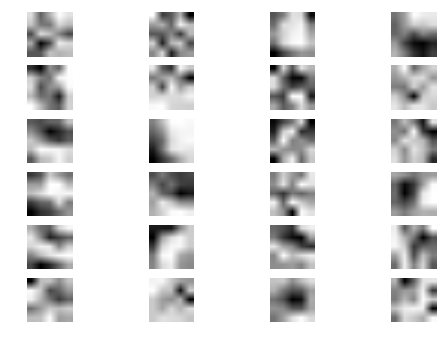

layer 1 channel 1 filters


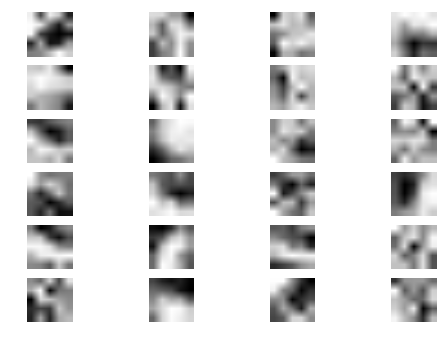

layer 1 channel 2 filters


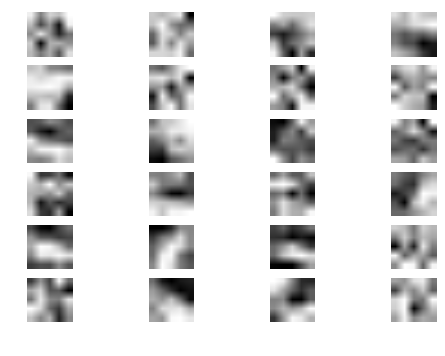

In [41]:
# in second layer we have [11,11,3,32] , or 96, 11x11 filters graph below shows them all 

for layer in range(3):
    fig,axes = plt.subplots(6,4)
    for i,ax in enumerate(axes.flat):
    # for i in range(filterSummary.shape[3]):
        img = filterSummary[0][0:,0:,layer,i]
        ax.axis('off')
        ax.imshow(img)
    print('layer 1 channel {} filters'.format(layer))
    plt.show()



### visualizing Layer 2 the filters

layer 1 channel 0 filters


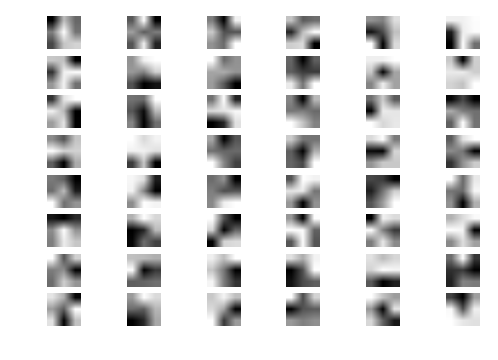

layer 1 channel 1 filters


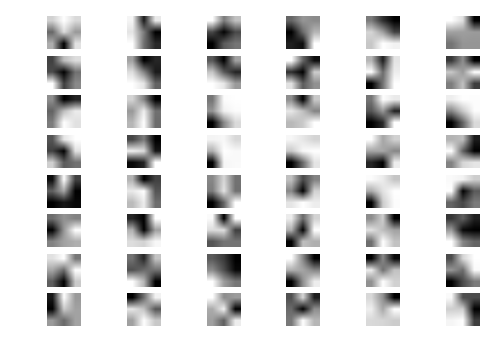

layer 1 channel 2 filters


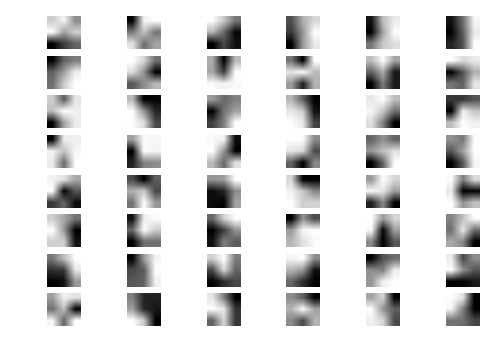

In [42]:
for layer in range(3):
    fig,axes = plt.subplots(8,6)
    for i,ax in enumerate(axes.flat):
    # for i in range(filterSummary.shape[3]):
        img = filterSummary[1][0:,0:,layer,i]
        ax.axis('off')
        ax.imshow(img)
    print('layer 1 channel {} filters'.format(layer))
    plt.show()

### visualizing Layer 3 the filters

layer 1 channel 0 filters


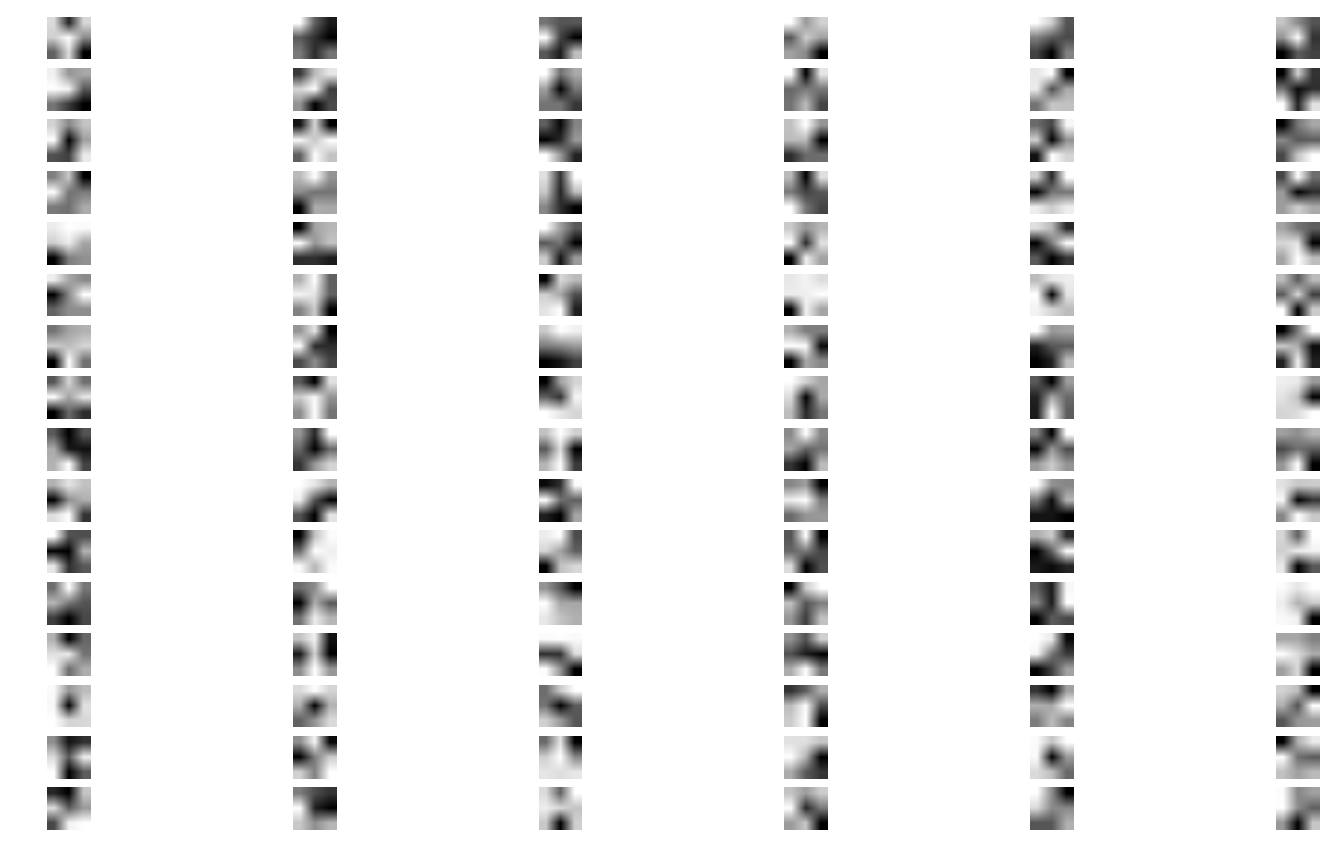

layer 1 channel 1 filters


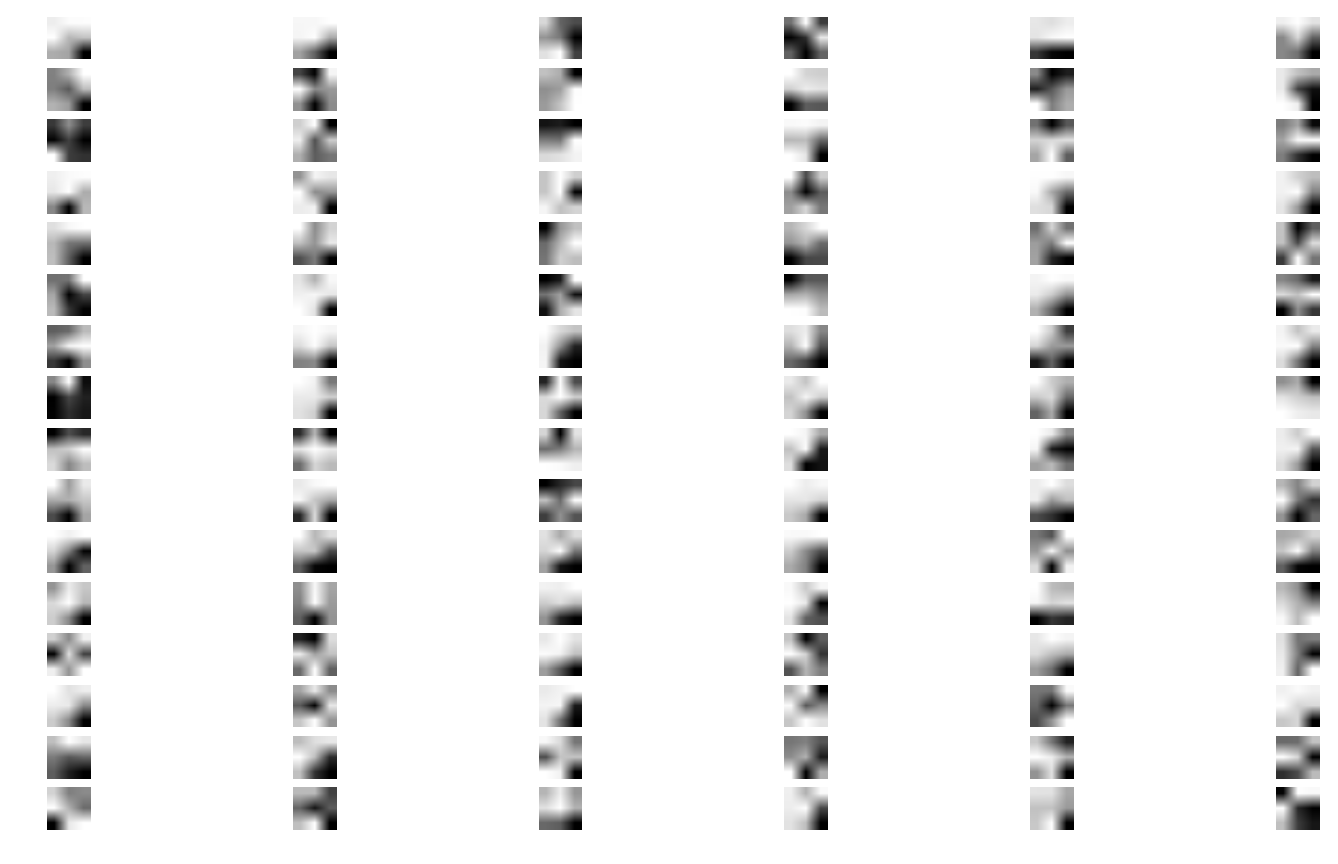

layer 1 channel 2 filters


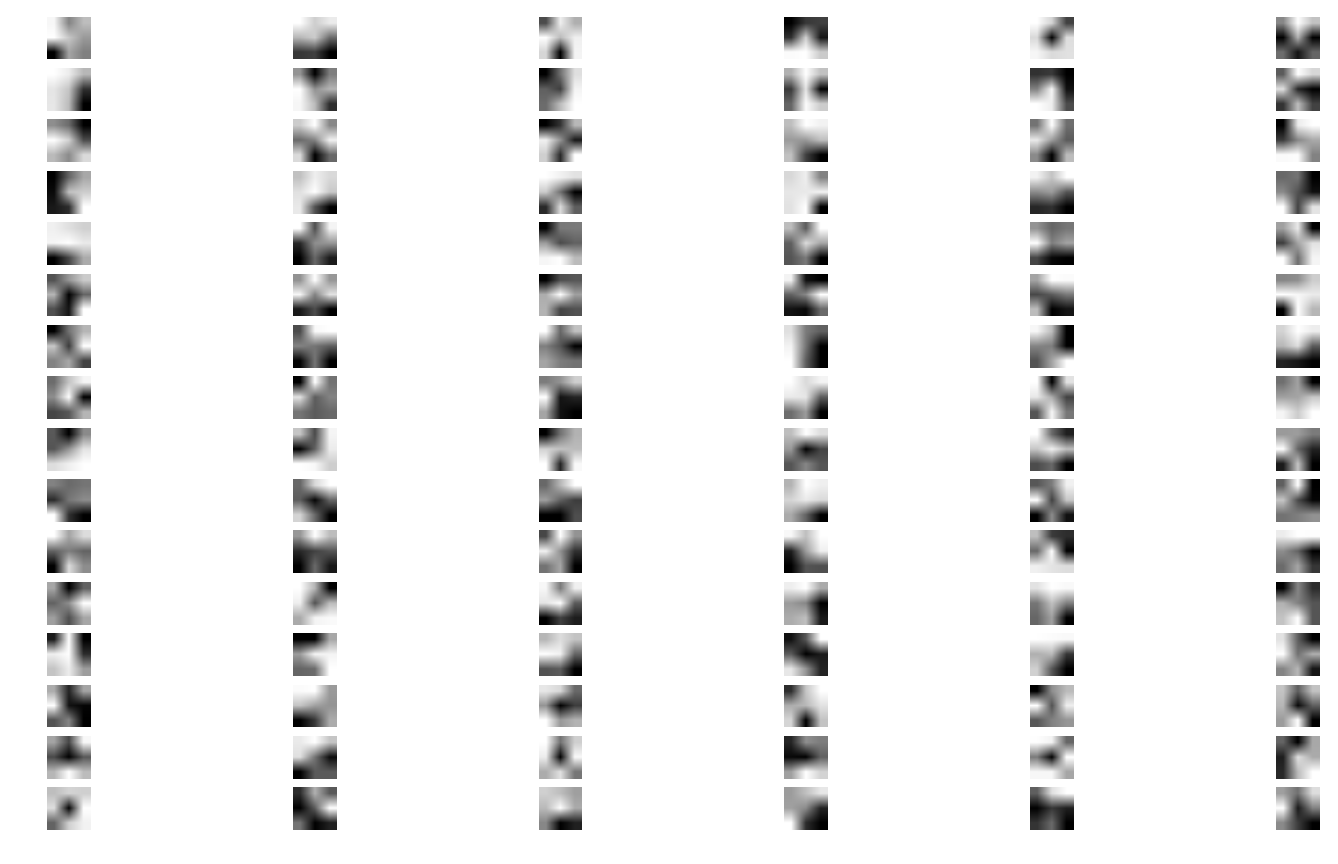

In [43]:
for layer in range(3):
    fig,axes = plt.subplots(16,6)
    for i,ax in enumerate(axes.flat):
    # for i in range(filterSummary.shape[3]):
        img = filterSummary[2][0:,0:,layer,i]
        ax.axis('off')
        ax.imshow(img)
    print('layer 1 channel {} filters'.format(layer))
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.show()


In [44]:
# --todo-- this function does load the model for me offline. I have to train the model from scratch each time fix !
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_loss, test_accuracy = evaluate(X_testScaled, y_test, 1.0)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Loss     = 0.394
Test Accuracy = 0.972


In [45]:
def plot_confusion_matrix(classPrediction,classLabels,numClasses):
    cm = confusion_matrix(y_true=classLabels,
                          y_pred=classPrediction)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(numClasses)
    plt.xticks(tick_marks, range(numClasses))
    plt.yticks(tick_marks, range(numClasses))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.show()

### Confusion Matrix of Test Data

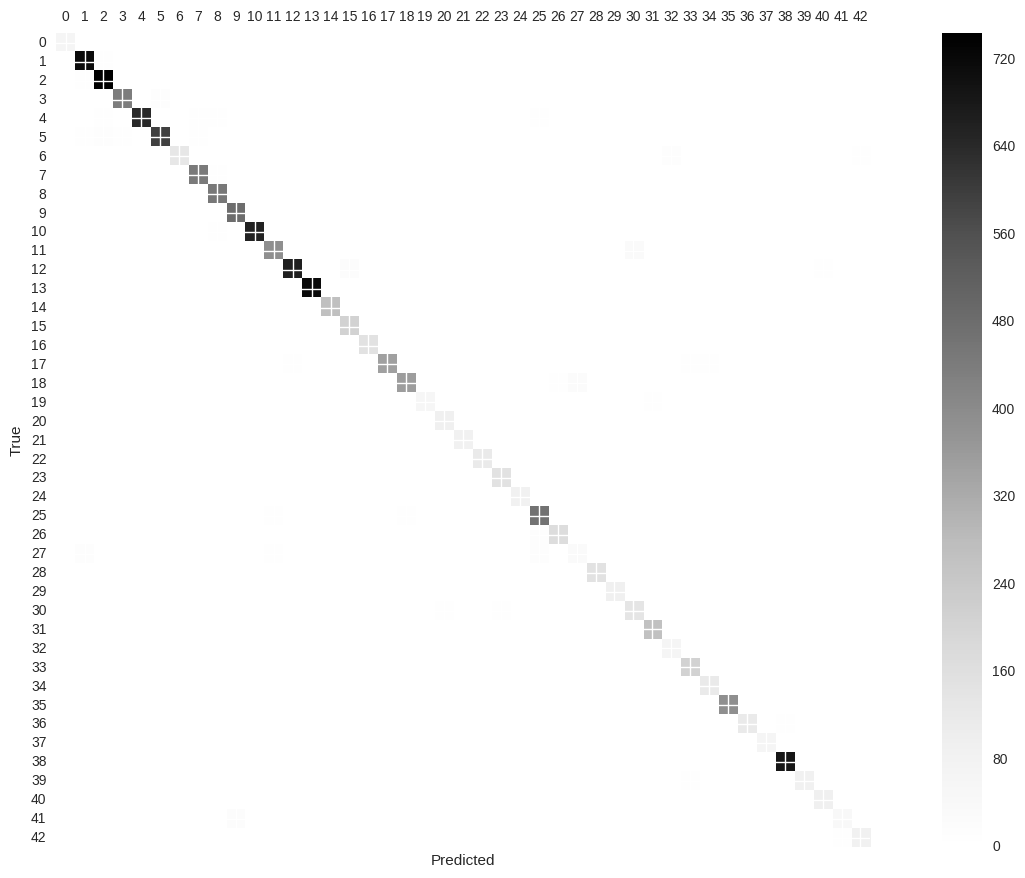

In [49]:
# to get the data i want i defined  a new set of operations and called them inside a tensor flow session. 
X_data = flatMaker(X_testScaled)
y_data = y_test
# this operation returns the predicted calss for all inputs pass to it
samplePrediction = tf.argmax(logits, 1)
# this operation returns the top k predictions from each input 
_,topKPrediction = tf.nn.top_k(logits, 3)
# this operation tells me if a sample was misclassified or not (the response is a boolean vector the size of data that is passed to it)
wrongPrediction = tf.not_equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
trueClass = tf.argmax(one_hot_y, 1)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    predictedClass,topKPredictions,wrongPredictions,trueClasses =  sess.run([samplePrediction,
                                               topKPrediction,
                                               wrongPrediction,
                                               trueClass],
                                               feed_dict={x: X_data, y: y_data, keep_prob : 1.0})
plot_confusion_matrix(predictedClass,y_test,numClasses = 43)


### sample of mistakes from the model and the top 3 predicted labels.

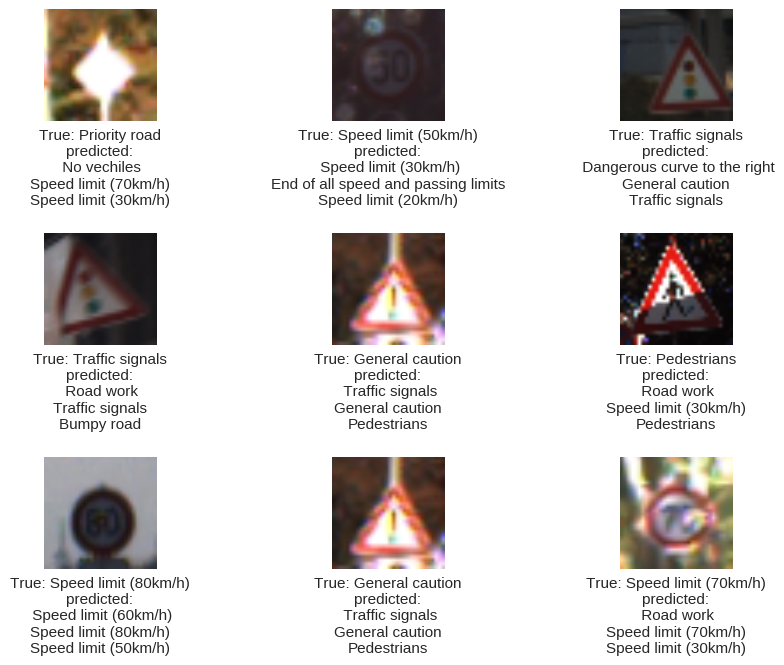

In [50]:
# calculate and plot for each sample top n classified 
mistakes2Graph = list()
for predic,topK,mistake,true,i in zip(predictedClass,topKPredictions,wrongPredictions,trueClasses,range(len(predictedClass))):
    if mistake == True:
        # getting the topK for only mis-classified samples with the index of their images 
        mistakes2Graph.append((true,topK,mistake,i))
 
# plotting the images that were misclassfied 
inde = np.random.randint(0, high=len(mistakes2Graph), size=9, dtype='l')
inde2 = [mistakes2Graph[i][-1] for i in inde]
images = X_test[inde2]

# # Get the true classes for those images.
trueClass = y_test[inde2]
predictedClass = predictedClass[inde2]

# Plot the images and labels using our helper-function above.
plot_images(images, trueClass, [mistakes2Graph[i][1] for i in inde] )    

In [48]:
len(mistakes2Graph)

0

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

in the course of almost 1 week, i applied a vareity of changes to the model. Mostly in a trial and error fashion:

    1- added more CONV layers to the original model. 
    2- defined an initial CONV layer that reduced the color channels to 1 (it is like gray scaling, but letting the model decide what color channel is the best. The model performance did not improve. 
    3- added drop out with different probabilities for the first fully connected layer. The drop out probability was set to 100% during prediction. 
    4- tried a varying the activation function from sigmoid to ReLU. ReLU activation generally gave better results 
    5- Varied the number of filters and size of the FC layers. Adding more layers or filters did not necessarily improved performance.
    6- I also tried connecting the output from the first CONV to the first FC layer as one of the papers suggested, but did not see any improvements in results. 
    7- L2 regularization was added to the model to prevent over-fitting
    8- early training termination based on incremental improvements on validation accuracy was set to prevent over-fitting 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [51]:
import numpy as np
import cv2
# importing the images i downloaded online into the session.
# training_file = '/media/pemfir/Data/docker/lab 2 data/train2.p'
# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
# X_train2 = train['features'].astype('float32')

# # # converting images from some Uni format to float32 for math operation 
# # X_train = train['features'].astype('float32')



# X_train_dummy = np.empty((X_train2.shape[0],imageSize,imageSize,3)) 


# for i in range(len(X_train2)):
#     X_train_dummy[i] = cv2.resize(X_train2[i],(imageSize, imageSize), interpolation = cv2.INTER_CUBIC)


# X_train2=X_train_dummy    


#  rgbimage = cv2.cvtColor(bgrimage, cv2.COLOR_BGR2RGB) 
# changing the shape of the images to (32x32x3)
for i in range(1,10):
        exec("""imageOriginal"""+str(i)+""" = plt.imread('/media/pemfir/Data/docker/traffic-signs/CarND-LeNet-Lab/onlinePhotos/imag"""+str(i)+"""B.jpg')
resizedOriginal_image"""+str(i)+""" = cv2.resize(imageOriginal"""+str(i)+""", (imageSize,imageSize)) 
resizedOriginal_image"""+str(i)+""" = np.reshape(resizedOriginal_image"""+str(i)+""",([1]+list(resizedOriginal_image"""+str(i)+""".shape)))
""")


XOriginal_data = np.vstack((resizedOriginal_image1,
                    resizedOriginal_image2,
                    resizedOriginal_image3,
                    resizedOriginal_image4,
                    resizedOriginal_image5,
                    resizedOriginal_image6,
                    resizedOriginal_image7,
                    resizedOriginal_image8,
                    resizedOriginal_image9))

# rescaling the images identical to the operation i performed to the training 
# resized_image = (XOriginal_data - 128.0)/(128.0)
# resized_image = (XOriginal_data - np.mean(X_train2,axis=0))/(np.std(X_train2,axis=0))
# resized_image = (resized_image - np.min(resized_image,axis=0))/(np.max(resized_image,axis=0) - np.min(resized_image,axis=0))
XOriginal_data2 = resized_image
finalResized_image = np.reshape(resized_image,([9]+[np.prod(resized_image.shape[1:])]))
X_data = finalResized_image


In [ ]:
for i in range(1,10):
        exec("""image"""+str(i)+""" = plt.imread('./imag"""+str(i)+""".jpg')

In [52]:
import tensorflow as tf
# X_data = X_data[0:2]
# defining operations to get top and topk predicted classes 
samplePrediction = tf.argmax(tf.nn.softmax(logits), 1)
topKPrediction = tf.nn.top_k(tf.nn.softmax(logits), 4)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    predictedClass,topKPredictions =  sess.run([samplePrediction,
                                               topKPrediction],
                                               feed_dict={x: X_data, keep_prob : 1.0})


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Despite a few of the signs not being in training or test set, the model was able to classify 5 of the images correctly (55% accuracy). I was disappointed that the 50km speed limit sign was not detected correctly, but later realized that the official signs have a white ring around them. I added a second 50 km speed limit to my images with the white ring, and the model was able to pick it up correctly. I can also see how the yellow signs were classified as priority road. The priority road sign is has a yellow diamond shape. One fot the differences between theses images and the ones in the training set is that these images have better color quality and are generally more colorful. I suspect using grayscales rather than colors may result in more robust predictions. The blue sign with right pointing arrow is very similar to the official keep right german traffic sign. it was interesting to see that the model picked this label for the sign.  

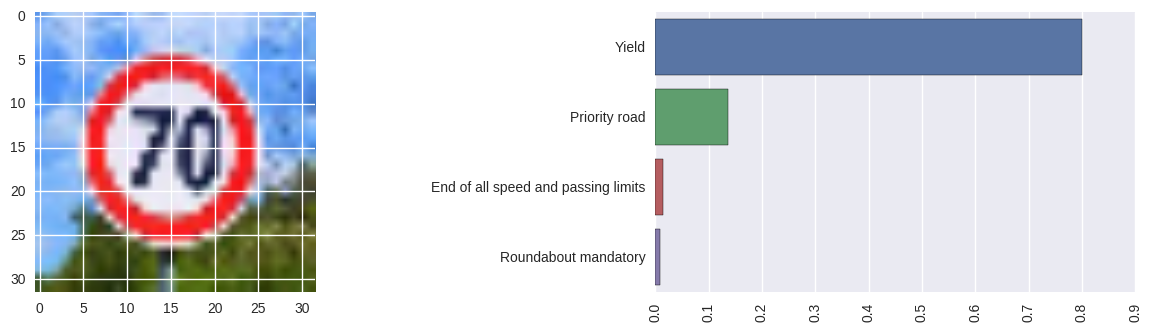

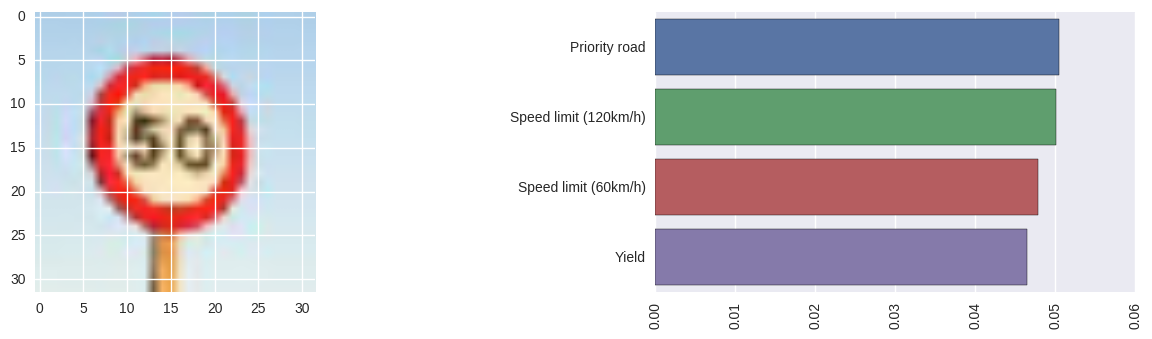

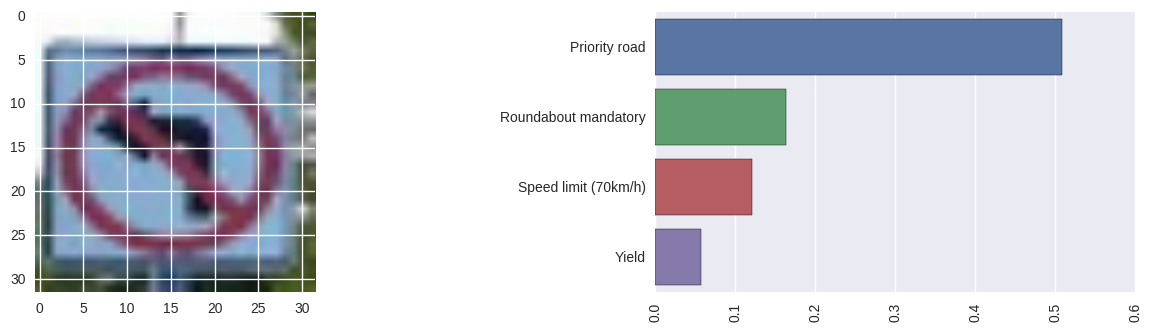

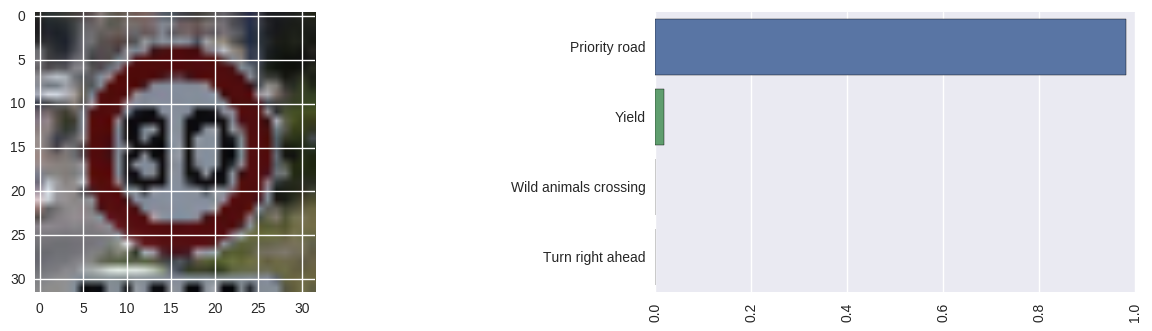

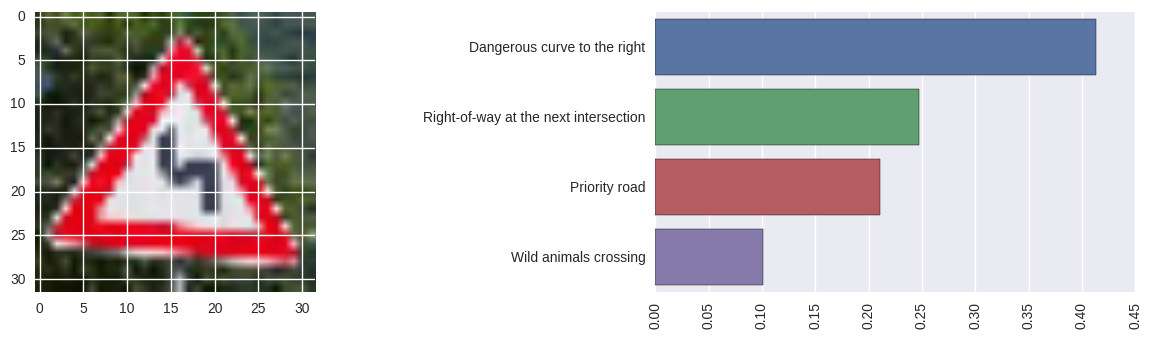

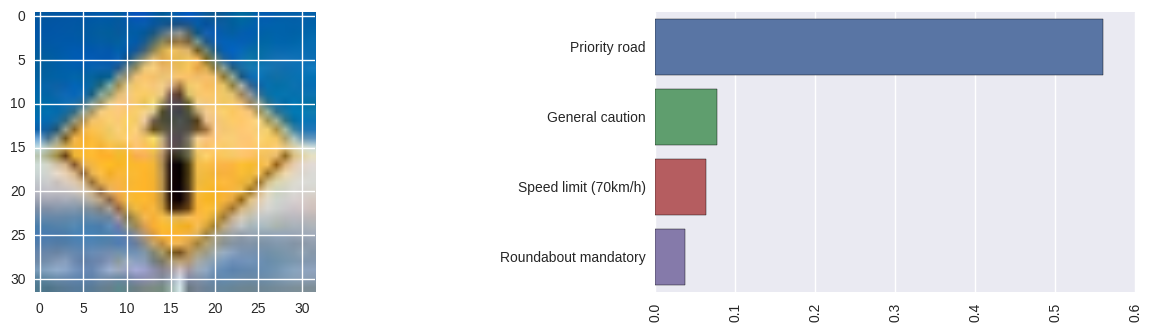

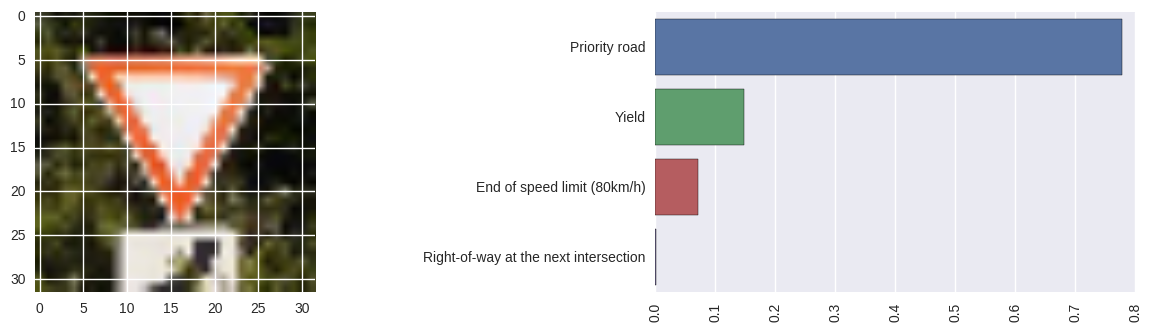

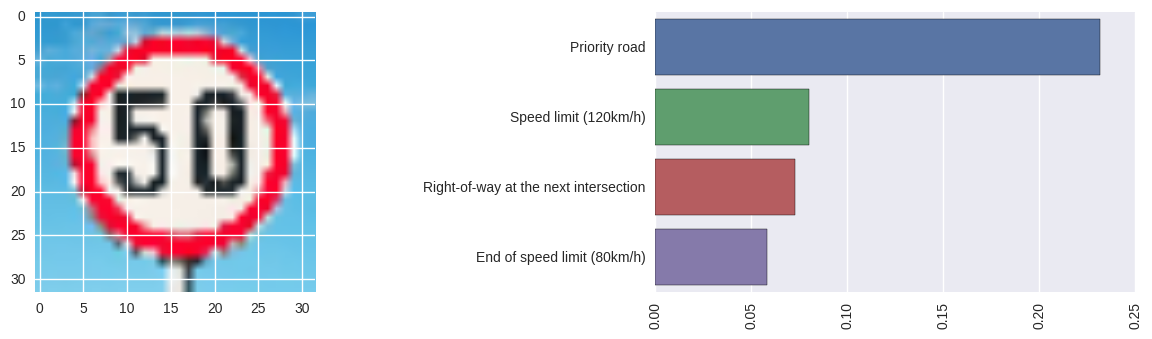

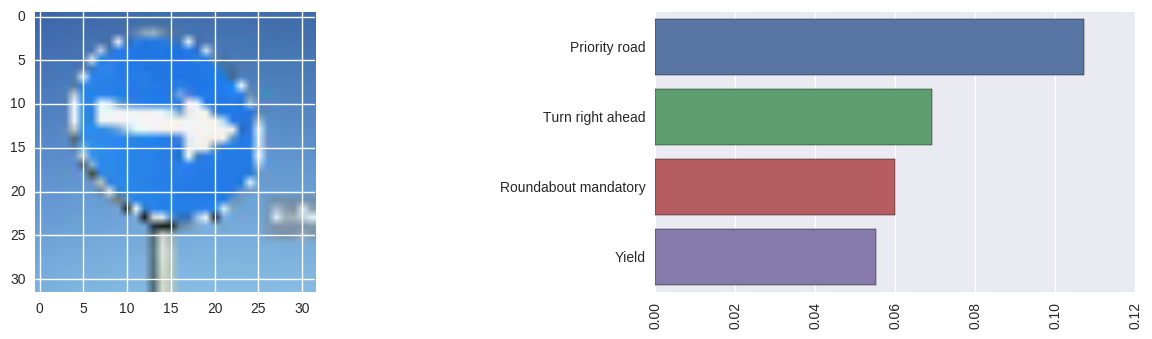

In [53]:
import seaborn as sns
for i in range(9):
    fig, axes = plt.subplots(1, 2,figsize=(10,2))
    left  = 0.2  # the left side of the subplots of the figure
    right = 1.4    # the right side of the subplots of the figure
    bottom = .1   # the bottom of the subplots of the figure
    top = 1.5      # the top of the subplots of the figure
    wspace = .5   # the amount of width reserved for blank space between subplots
    hspace = 1   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    for j, ax in enumerate(axes.flat):
        if j == 1:
            f = sns.barplot(y = [labelsDict[k] for k in topKPredictions[1][i]],x=topKPredictions[0][i])
            for item in f.get_xticklabels():
                item.set_rotation(90)
        if j == 0:
            ax.imshow(XOriginal_data[i])
       

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

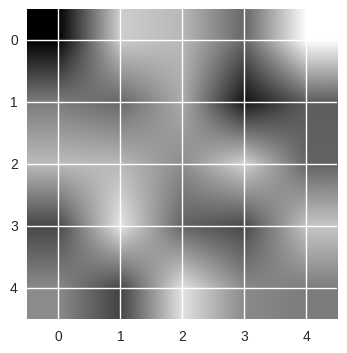

In [40]:
# Read saved model and get list of tensor variable
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/inspect_checkpoint.py
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
reader = tf.train.NewCheckpointReader('./lenet')
reader.get_variable_to_shape_map()
# Read saved model and inspect various tensor values
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/inspect_checkpoint.py
tens = reader.get_tensor("CONVLayer1/Variable")
#print (tens.shape)
#print (tens)
imgTest = tens[:,:,0,1]
plt.imshow(imgTest, cmap='gray')